# vae

implementing autoencoders, vae and f-vae on mnist


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    if torch.backends.mps.is_available():
        device = torch.device("mps")
except:
    pass

print(f"Using device: {device}")

# seed
torch.manual_seed(42)
np.random.seed(42)



Using device: cuda


## data


In [2]:

batch_size = 128

# transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

# mnist
train_dataset_mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset_mnist = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader_mnist = DataLoader(train_dataset_mnist, batch_size=batch_size, shuffle=True)
test_loader_mnist = DataLoader(test_dataset_mnist, batch_size=batch_size, shuffle=False)

# fashion mnist
train_dataset_fashion = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset_fashion = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
train_loader_fashion = DataLoader(train_dataset_fashion, batch_size=batch_size, shuffle=True)
test_loader_fashion = DataLoader(test_dataset_fashion, batch_size=batch_size, shuffle=False)

print("Datasets loaded.")



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.92MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 128kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.63MB/s]
100%|██████████| 26.4M/26.4M [00:02<00:00, 12.0MB/s]
100%|██████████| 29.5k/29.5k [00:01<00:00, 20.3kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.20MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.3MB/s]

Datasets loaded.


## 1. autoencoder


training simple autoencoder to check how latent size affects reconstruction.


Training Autoencoders with different latent sizes...
Training AE with latent_dim=2
Training AE with latent_dim=4
Training AE with latent_dim=8
Training AE with latent_dim=16
Training AE with latent_dim=32


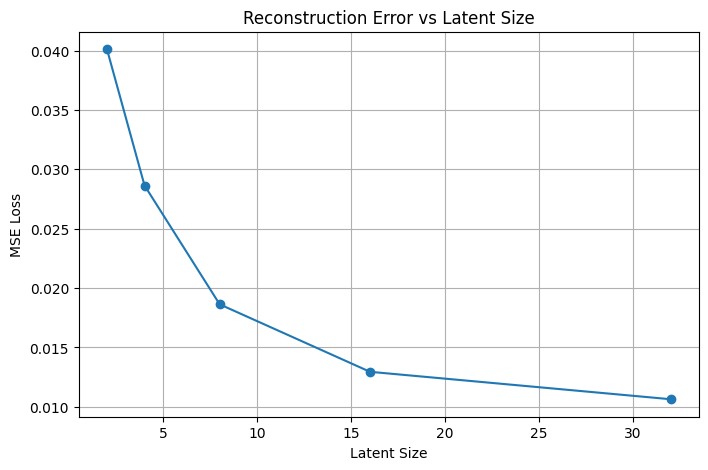

In [3]:

class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        # encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

def train_ae(model, loader, epochs=5):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    model.train()

    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for x, _ in loader:
            x = x.to(device)
            optimizer.zero_grad()
            recon = model(x)
            loss = criterion(recon, x)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(loader)
        losses.append(avg_loss)
    return losses[-1]

# experiment
latent_sizes = [2, 4, 8, 16, 32]
final_losses = []

print("Training Autoencoders with different latent sizes...")
for ld in latent_sizes:
    print(f"Training AE with latent_dim={ld}")
    model = Autoencoder(ld).to(device)
    loss = train_ae(model, train_loader_mnist, epochs=5)
    final_losses.append(loss)

# plot
plt.figure(figsize=(8, 5))
plt.plot(latent_sizes, final_losses, marker='o')
plt.title("Reconstruction Error vs Latent Size")
plt.xlabel("Latent Size")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()



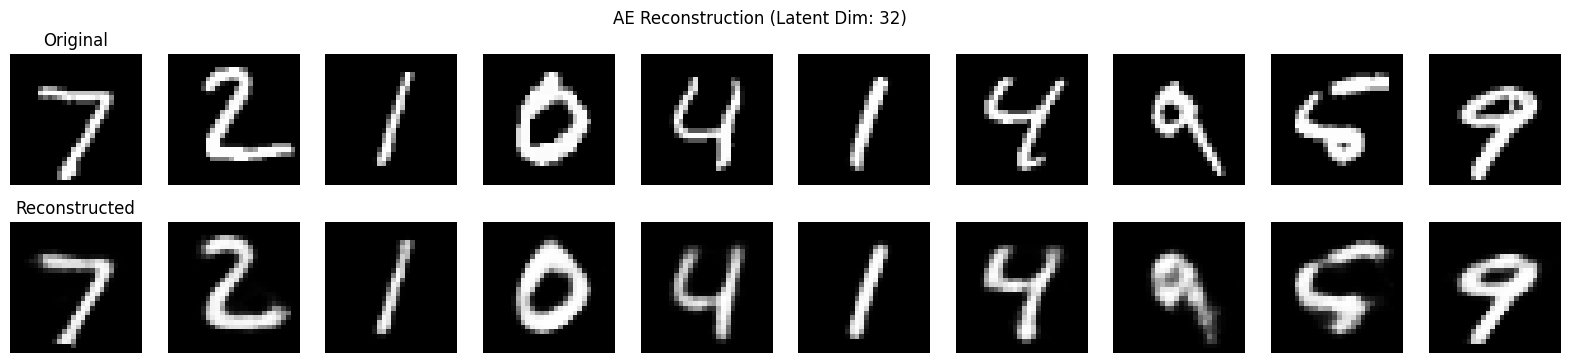

In [4]:

# vis best model
best_model = Autoencoder(latent_sizes[-1]).to(device)
train_ae(best_model, train_loader_mnist, epochs=5)

best_model.eval()
x, _ = next(iter(test_loader_mnist))
x = x[:10].to(device)
with torch.no_grad():
    recon = best_model(x)

x = x.cpu()
recon = recon.cpu()

fig, axes = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axes[0, i].imshow(x[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(recon[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')
axes[0, 0].set_title("Original")
axes[1, 0].set_title("Reconstructed")
plt.suptitle(f"AE Reconstruction (Latent Dim: {latent_sizes[-1]})")
plt.show()



## 2. vae


standard vae with elbo loss. comparing mnist vs fashion-mnist.


Training VAE on MNIST Digits...
Epoch 1, Loss: 164.4875
Epoch 2, Loss: 118.6499
Epoch 3, Loss: 113.2061
Epoch 4, Loss: 110.2695
Epoch 5, Loss: 108.5049
Epoch 6, Loss: 107.4250
Epoch 7, Loss: 106.6153
Epoch 8, Loss: 105.9036
Epoch 9, Loss: 105.4317
Epoch 10, Loss: 105.0385


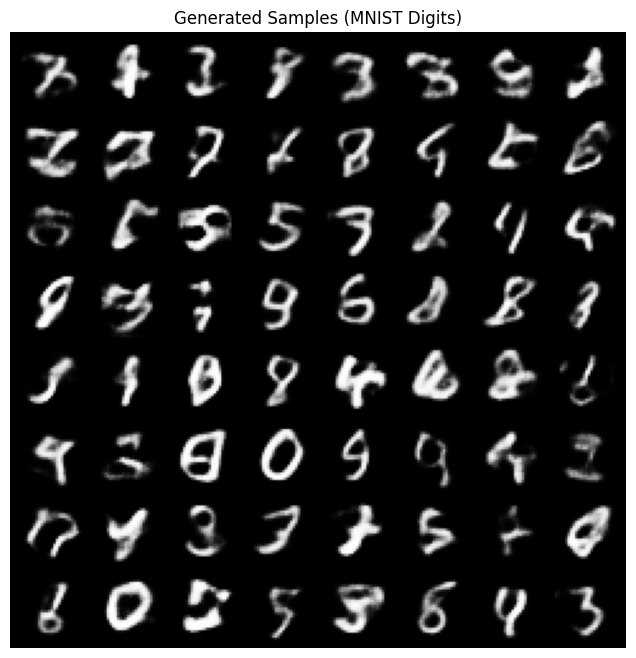

Training VAE on Fashion-MNIST...
Epoch 1, Loss: 286.5234
Epoch 2, Loss: 255.2156
Epoch 3, Loss: 250.7652
Epoch 4, Loss: 248.3587
Epoch 5, Loss: 246.8258
Epoch 6, Loss: 245.7513
Epoch 7, Loss: 244.9653
Epoch 8, Loss: 244.3380
Epoch 9, Loss: 243.8108
Epoch 10, Loss: 243.3739


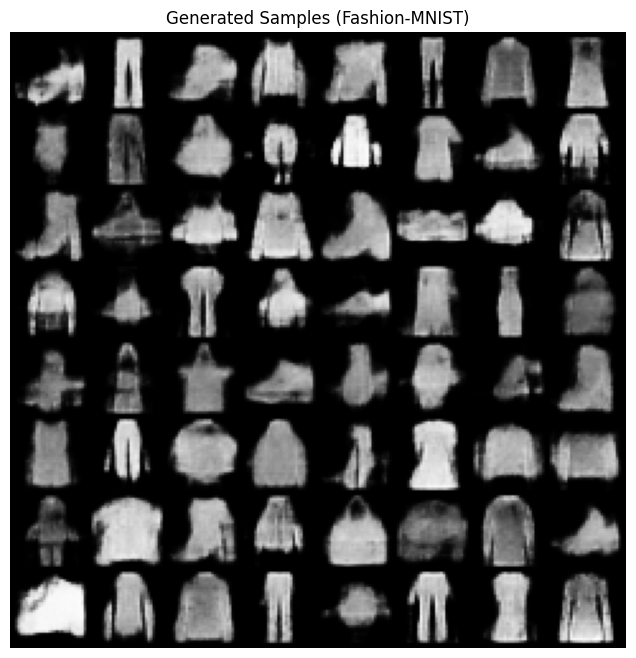

In [5]:

class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1), # 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 7x7
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)

        # decoder
        self.decoder_input = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), # 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1), # 28x28
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        z_dec = self.decoder_input(z)
        recon_x = self.decoder(z_dec)
        return recon_x, mu, logvar

def loss_vae(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    # kl divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train_vae_model(train_loader, name="MNIST", epochs=10):
    model = VAE(latent_dim=20).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    model.train()

    print(f"Training VAE on {name}...")
    losses = []
    for epoch in range(epochs):
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            recon_x, mu, logvar = model(x)
            loss = loss_vae(recon_x, x, mu, logvar)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_loss = train_loss / len(train_loader.dataset)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
    return model

def visualize_vae_generation(model, name="MNIST"):
    model.eval()
    with torch.no_grad():
        z = torch.randn(64, 20).to(device)
        z_dec = model.decoder_input(z)
        sample = model.decoder(z_dec).cpu()

        grid = torchvision.utils.make_grid(sample, nrow=8)
        plt.figure(figsize=(8, 8))
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis('off')
        plt.title(f"Generated Samples ({name})")
        plt.show()

# Train on MNIST
vae_mnist = train_vae_model(train_loader_mnist, "MNIST Digits", epochs=10)
visualize_vae_generation(vae_mnist, "MNIST Digits")

# Train on FashionMNIST
vae_fashion = train_vae_model(train_loader_fashion, "Fashion-MNIST", epochs=10)
visualize_vae_generation(vae_fashion, "Fashion-MNIST")



## 3. f-vae


using realnvp in latent space for better posterior.


Training f-VAE on MNIST Digits...
Epoch 1, Loss: 175.4368
Epoch 2, Loss: 120.0512
Epoch 3, Loss: 113.8022
Epoch 4, Loss: 110.1747
Epoch 5, Loss: 108.0605
Epoch 6, Loss: 106.6450
Epoch 7, Loss: 105.6441
Epoch 8, Loss: 104.8888
Epoch 9, Loss: 104.2595
Epoch 10, Loss: 103.7808


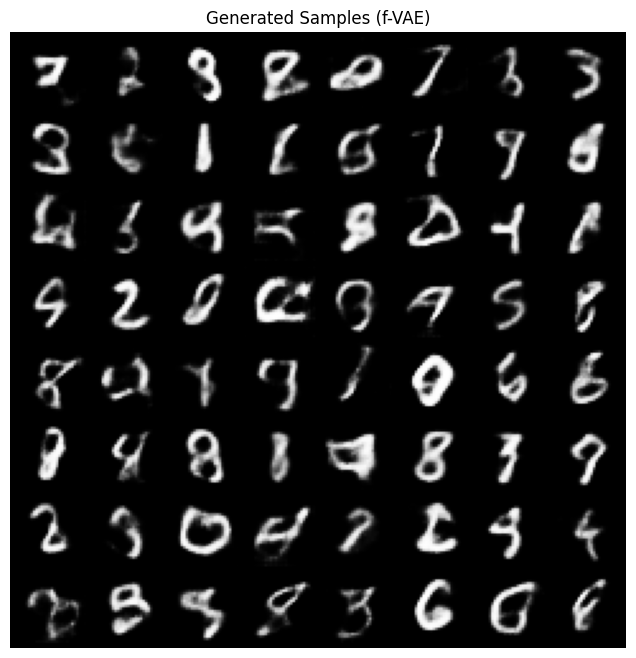

In [6]:

class PlanarFlow(nn.Module):
    # affine coupling layer
    def __init__(self, dim):
        super(PlanarFlow, self).__init__()
        # split dim
        self.s_net = nn.Sequential(
            nn.Linear(dim // 2, 64),
            nn.ReLU(),
            nn.Linear(64, dim // 2),
            nn.Tanh() # tanh for stability
        )
        self.t_net = nn.Sequential(
            nn.Linear(dim // 2, 64),
            nn.ReLU(),
            nn.Linear(64, dim // 2)
        )

    def forward(self, x):
        # x: [B, dim]
        dim = x.shape[1]
        half = dim // 2
        x1 = x[:, :half]
        x2 = x[:, half:]

        s = self.s_net(x1)
        t = self.t_net(x1)

        y1 = x1
        y2 = x2 * torch.exp(s) + t

        y = torch.cat([y1, y2], dim=1)
        log_det = torch.sum(s, dim=1)

        return y, log_det

class RealNVP1D(nn.Module):
    def __init__(self, dim, n_layers=4):
        super(RealNVP1D, self).__init__()
        self.layers = nn.ModuleList([PlanarFlow(dim) for _ in range(n_layers)])

    def forward(self, x):
        log_det_sum = 0
        for i, layer in enumerate(self.layers):
            if i % 2 == 1:
                # flip for mixing
                x = x.flip(dims=(1,))

            x, log_det = layer(x)
            log_det_sum += log_det

        return x, log_det_sum

class F_VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(F_VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)

        # Flow
        self.flow = RealNVP1D(latent_dim, n_layers=4)

        # decoder
        self.decoder_input = nn.Linear(latent_dim, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z0 = mu + eps * std
        return z0

    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        # sample z0
        z0 = self.reparameterize(mu, logvar)

        # flow transform
        zk, log_det_flow = self.flow(z0)

        # Decode zk
        z_dec = self.decoder_input(zk)
        recon_x = self.decoder(z_dec)

        return recon_x, mu, logvar, z0, zk, log_det_flow

def loss_f_vae(recon_x, x, mu, logvar, z0, zk, log_det_flow):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')

    # kl calculation




    # log q(z0|x)
    log_q_z0 = -0.5 * (torch.sum(logvar + (z0 - mu)**2 / logvar.exp(), dim=1) + mu.shape[1] * np.log(2 * np.pi))

    # log p(zk)
    log_p_zk = -0.5 * (torch.sum(zk**2, dim=1) + zk.shape[1] * np.log(2 * np.pi))

    # kl approx
    kl = log_q_z0 - log_det_flow - log_p_zk
    kl = torch.sum(kl)

    return BCE + kl

# Train f-VAE
f_vae = F_VAE(latent_dim=20).to(device)
optimizer = optim.Adam(f_vae.parameters(), lr=1e-3)

print("Training f-VAE on MNIST Digits...")
for epoch in range(10):
    f_vae.train()
    train_loss = 0
    for x, _ in train_loader_mnist:
        x = x.to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar, z0, zk, log_det_flow = f_vae(x)
        loss = loss_f_vae(recon_x, x, mu, logvar, z0, zk, log_det_flow)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader_mnist.dataset):.4f}")

# Generation
f_vae.eval()
with torch.no_grad():
    # sampling from prior


    z_sample = torch.randn(64, 20).to(device)
    z_dec = f_vae.decoder_input(z_sample)
    x_gen = f_vae.decoder(z_dec).cpu()

    grid = torchvision.utils.make_grid(x_gen, nrow=8)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title("Generated Samples (f-VAE)")
    plt.show()



## 4. beta-vae (bonus)


changing beta weight for kl term to see disentanglement.


In [7]:

def loss_beta_vae(recon_x, x, mu, logvar, beta=1.0):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD

def train_beta_vae(beta, train_loader, epochs=10):
    model = VAE(latent_dim=10).to(device) # small latent for vis
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    model.train()

    print(f"Training Beta-VAE (beta={beta})...")
    losses = []
    for epoch in range(epochs):
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            recon_x, mu, logvar = model(x)
            loss = loss_beta_vae(recon_x, x, mu, logvar, beta=beta)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_loss = train_loss / len(train_loader.dataset)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
    return model

def visualize_latent_traversal(model, latent_dim=10, traversal_range=(-3, 3), steps=15):
    model.eval()

    # traverse dims
    fig, axes = plt.subplots(latent_dim, steps, figsize=(steps, latent_dim))

    # traversal grid
    grid_x = torch.linspace(traversal_range[0], traversal_range[1], steps).to(device)

    with torch.no_grad():
        for dim in range(latent_dim):
            z = torch.zeros(steps, latent_dim).to(device)
            z[:, dim] = grid_x

            # Decode
            z_dec = model.decoder_input(z)
            samples = model.decoder(z_dec).cpu()

            for i in range(steps):
                axes[dim, i].imshow(samples[i].squeeze(), cmap='gray')
                axes[dim, i].axis('off')
                if i == 0:
                    axes[dim, i].set_title(f"Dim {dim}", loc='left', fontsize=8)

    plt.suptitle("Latent Traversal", y=1.02)
    plt.tight_layout()
    plt.show()



### high beta (4.0)


Training Beta-VAE (beta=4.0)...
Epoch 1, Loss: 208.6156
Epoch 2, Loss: 165.7142
Epoch 3, Loss: 159.2920
Epoch 4, Loss: 156.5867
Epoch 5, Loss: 155.0371
Epoch 6, Loss: 153.8426
Epoch 7, Loss: 152.8968
Epoch 8, Loss: 152.0770
Epoch 9, Loss: 151.4461
Epoch 10, Loss: 150.9155


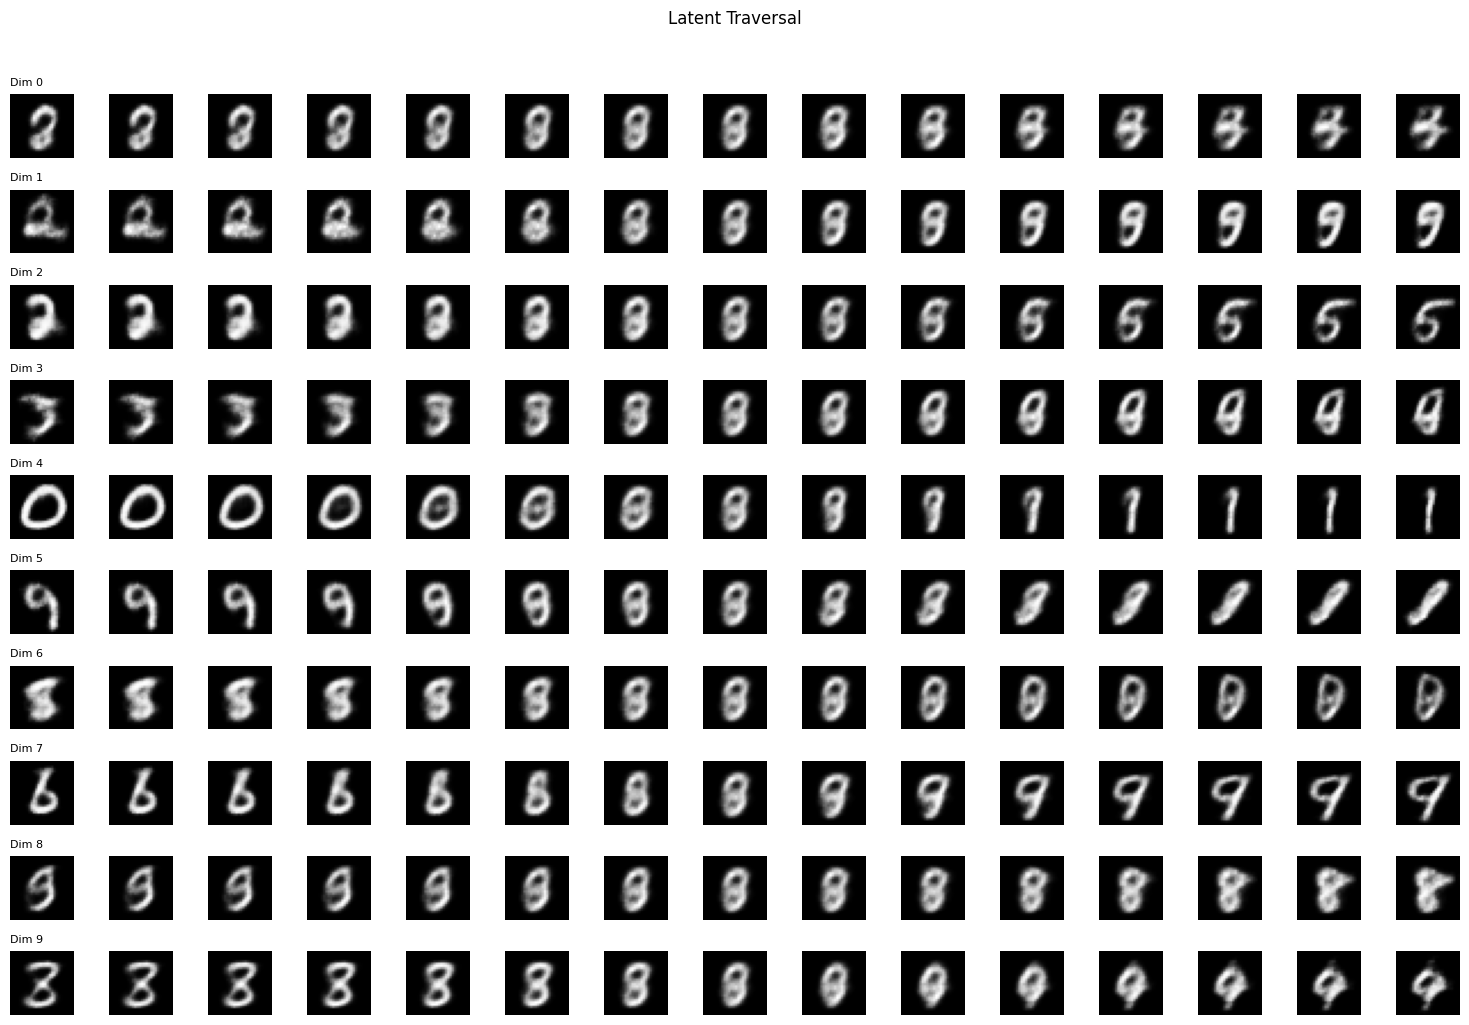

In [8]:

beta_high = 4.0
model_beta_high = train_beta_vae(beta_high, train_loader_mnist, epochs=10)
visualize_latent_traversal(model_beta_high, latent_dim=10)



### low beta (0.5)


Training Beta-VAE (beta=0.5)...
Epoch 1, Loss: 174.6972
Epoch 2, Loss: 122.8391
Epoch 3, Loss: 114.4029
Epoch 4, Loss: 109.4354
Epoch 5, Loss: 106.5335
Epoch 6, Loss: 104.6983
Epoch 7, Loss: 103.3864
Epoch 8, Loss: 102.3311
Epoch 9, Loss: 101.4585
Epoch 10, Loss: 100.7497


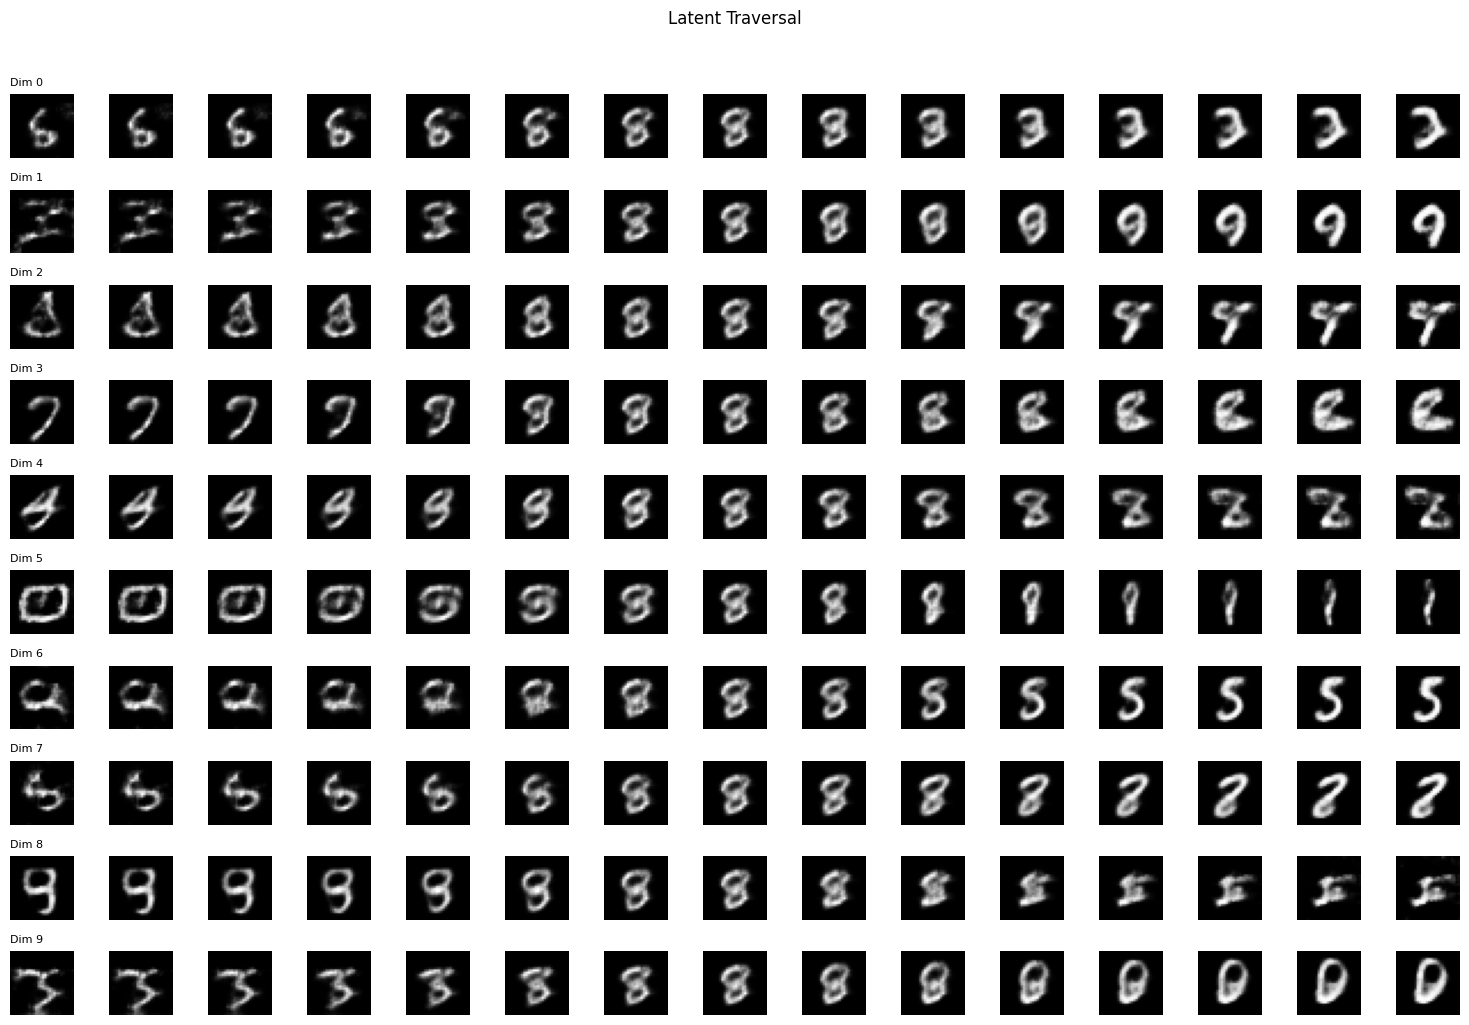

In [9]:

beta_low = 0.5
model_beta_low = train_beta_vae(beta_low, train_loader_mnist, epochs=10)
visualize_latent_traversal(model_beta_low, latent_dim=10)

